# [11.11 Learning Rate Scheduling](https://d2l.ai/chapter_optimization/lr-scheduler.html#summary)

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
plt.rc('font', size=16)

import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### DataSet : FashionMNIST

In [2]:
fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transforms.ToTensor(), download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transforms.ToTensor(), download=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


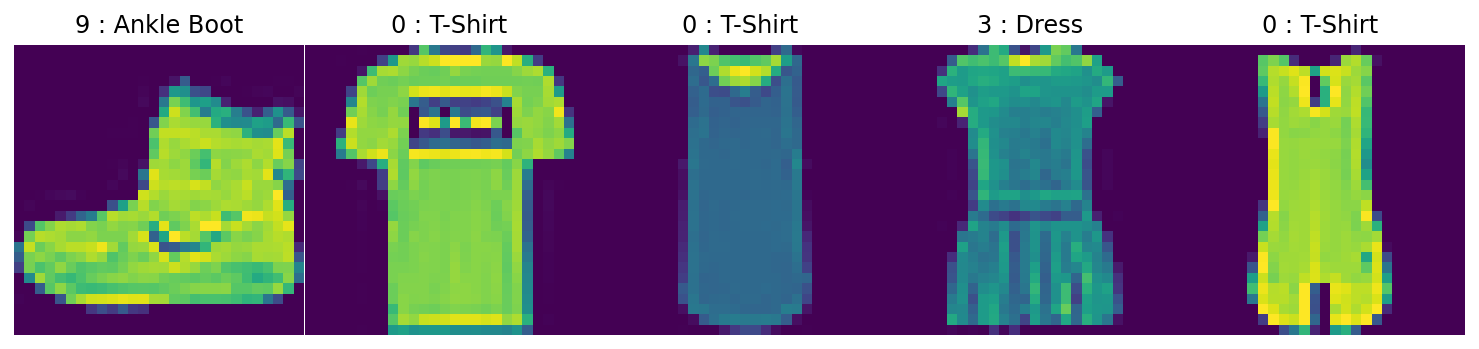

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
plt.subplots_adjust(hspace=0.001, wspace=0.001)

for i in range(5):
    image, label = fmnist_train.__getitem__(i)
    axes[i].imshow(image.squeeze().numpy())
    axes[i].set_title(f'{label} : {labels_map[label]}')
    axes[i].axis('off')

In [4]:
batch_size = 256

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

# Toy Problem

### Define a modernized version of LeNet

- Replace all the average pooling with maximum pooling (``nn.AvgPool2d`` -> `nn.MaxPool2d`)
- Use ``ReLU`` instead of ``Sigmoid`` activation function.

(See [§6.6](./6.4_6.6%20CNN_2.ipynb) for the original version of LeNet.)

In [5]:
def net_fn():
    
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10)
        )
    
    return model

### Loss Function

In [6]:
criterion = nn.CrossEntropyLoss()

### Training Loop

In [7]:
def train_1_epoch(model, optimizer, train_loss, train_acc, lr_record, scheduler=None):
    
    model.train()              # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
    
    # -- End training for 1 epoch -- record statistics
    if scheduler:
        scheduler.step()
    
    lr_record.append(optimizer.state_dict()['param_groups'][0]['lr'])
    #lr_record.append(scheduler.get_last_lr()[0]) # if scheduler is specified
    
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    
    if (epoch%3)==0 :
        print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    if (epoch%3)==0 :
        print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

## 0. Train without scheduler

In [8]:
initial_lr = 0.3

net0 = net_fn()
net0.to(device)

optimizer0 = torch.optim.SGD(net0.parameters(), lr=initial_lr)

train_loss0 = []
train_acc0 = []
valid_loss0 = []
valid_acc0 = []
lr_record0 = []

num_epochs = 30
for epoch in range(0, num_epochs):
    train_1_epoch(net0, optimizer0, train_loss0, train_acc0, lr_record0, scheduler=None)
    validation(net0, valid_loss0, valid_acc0)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


>>> End epoch 1, train accuracy = 52.06%, train avgLoss = 1.2822
>>>              valid accuracy = 67.30%, valid avgLoss = 0.7339
>>> End epoch 4, train accuracy = 85.66%, train avgLoss = 0.3842
>>>              valid accuracy = 84.42%, valid avgLoss = 0.4275
>>> End epoch 7, train accuracy = 88.24%, train avgLoss = 0.3141
>>>              valid accuracy = 87.02%, valid avgLoss = 0.3669
>>> End epoch 10, train accuracy = 89.53%, train avgLoss = 0.2782
>>>              valid accuracy = 86.32%, valid avgLoss = 0.3687
>>> End epoch 13, train accuracy = 90.33%, train avgLoss = 0.2548
>>>              valid accuracy = 85.76%, valid avgLoss = 0.4133
>>> End epoch 16, train accuracy = 91.12%, train avgLoss = 0.2346
>>>              valid accuracy = 86.34%, valid avgLoss = 0.3726
>>> End epoch 19, train accuracy = 91.67%, train avgLoss = 0.2172
>>>              valid accuracy = 88.76%, valid avgLoss = 0.3263
>>> End epoch 22, train accuracy = 92.24%, train avgLoss = 0.1990
>>>              val

### Plot

Text(0.5, 0.98, 'constant learning rate')

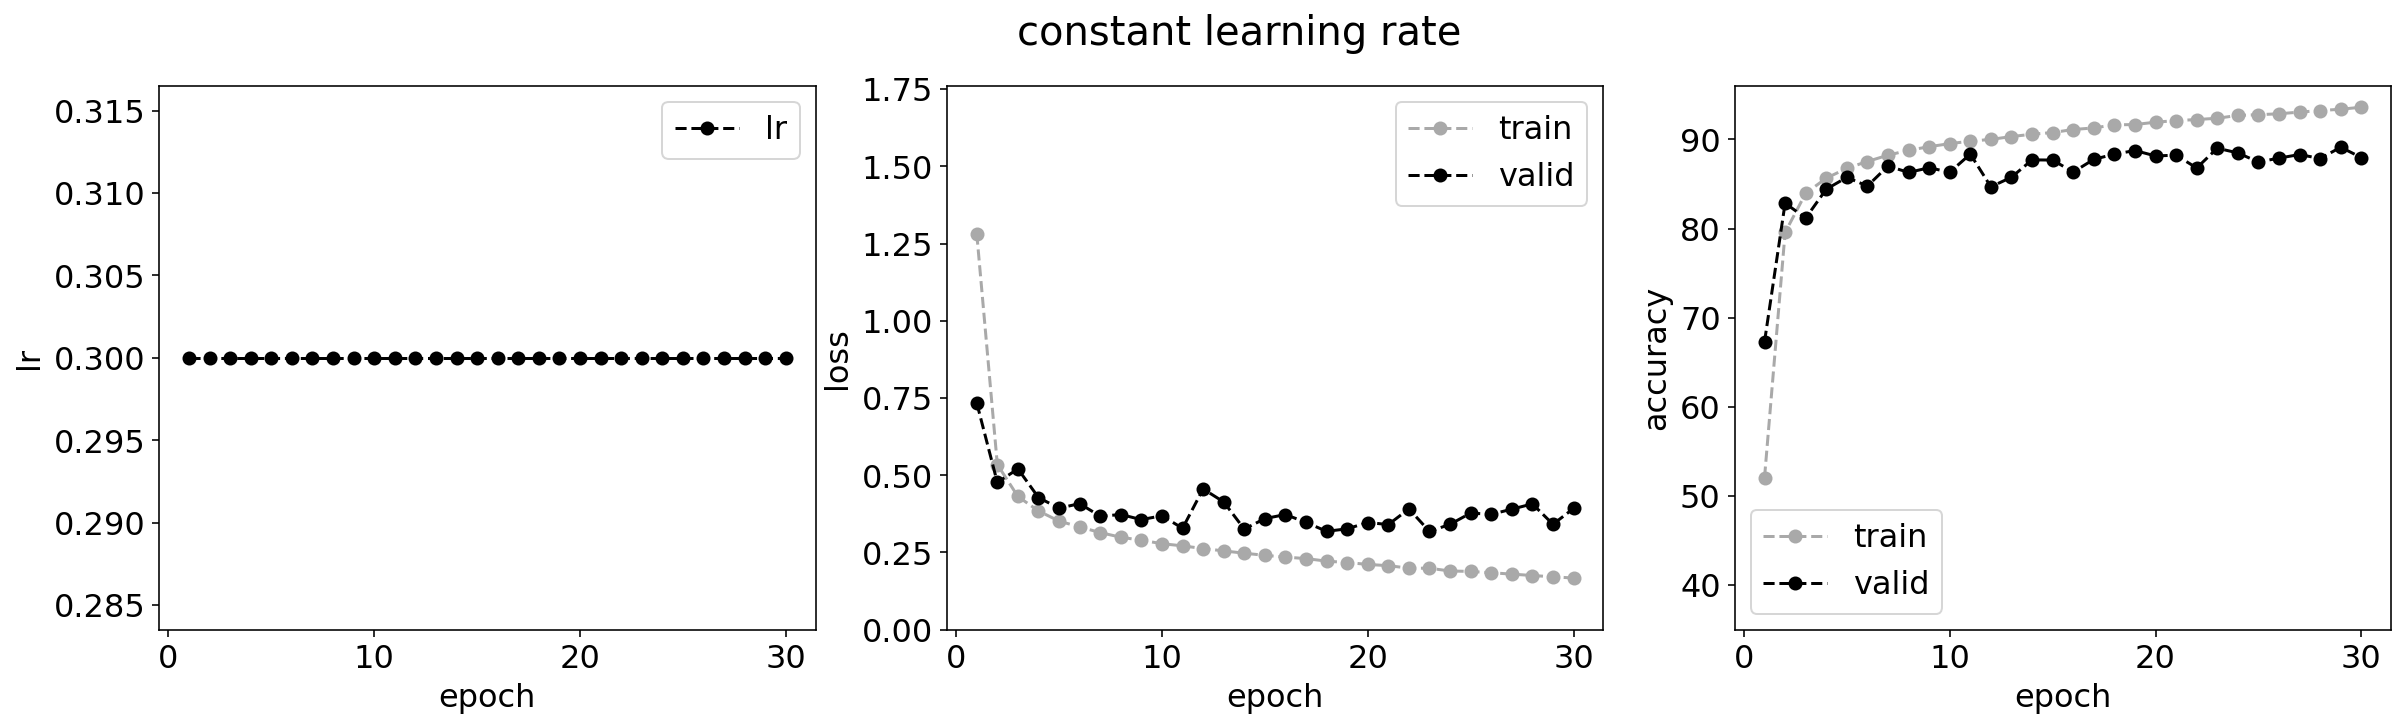

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1), lr_record0, 'o--', label='lr', color='k')
ax[0].set_ylabel('lr')

ax[1].plot(range(1,num_epochs+1)[::], train_loss0[::], 'o--', label='train', color='darkgray')
ax[1].plot(range(1,num_epochs+1)[::], valid_loss0[::], 'o--', label='valid', color='k')
ax[2].plot(range(1,num_epochs+1)[::], train_acc0[::] , 'o--', label='train', color='darkgray')
ax[2].plot(range(1,num_epochs+1)[::], valid_acc0[::], 'o--', label='valid', color='k')

ax[1].set_ylabel('loss')
ax[2].set_ylabel('accuracy')

ax[1].set_ylim(0, 1.76)
ax[2].set_ylim(35, 96)


for i in range(3):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

fig.suptitle('constant learning rate', fontsize=20)

## 1. Train with Learning Rate Scheduler

In [11]:
net = net_fn()
net.to(device)

initial_lr = 0.3 # initial learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=initial_lr)

### SquareRootScheduler

``torch.optim.lr_scheduler.LambdaLR``

In [12]:
lambda1 = lambda epoch : (epoch+1)**-0.5     # For each epoch, multiply initial_lr*(epoch+1)^0.5
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1)

In [13]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
lr_record = []

num_epochs = 30
for epoch in range(0, num_epochs):
    train_1_epoch(net, optimizer, train_loss, train_acc, lr_record, scheduler)

    validation(net, valid_loss, valid_acc)

>>> End epoch 1, train accuracy = 50.61%, train avgLoss = 1.2810
>>>              valid accuracy = 70.35%, valid avgLoss = 0.7898
>>> End epoch 4, train accuracy = 85.89%, train avgLoss = 0.3748
>>>              valid accuracy = 85.25%, valid avgLoss = 0.3959
>>> End epoch 7, train accuracy = 88.19%, train avgLoss = 0.3155
>>>              valid accuracy = 84.93%, valid avgLoss = 0.4065
>>> End epoch 10, train accuracy = 89.35%, train avgLoss = 0.2854
>>>              valid accuracy = 88.31%, valid avgLoss = 0.3273
>>> End epoch 13, train accuracy = 90.08%, train avgLoss = 0.2651
>>>              valid accuracy = 88.56%, valid avgLoss = 0.3110
>>> End epoch 16, train accuracy = 90.54%, train avgLoss = 0.2514
>>>              valid accuracy = 89.29%, valid avgLoss = 0.2999
>>> End epoch 19, train accuracy = 91.02%, train avgLoss = 0.2385
>>>              valid accuracy = 89.04%, valid avgLoss = 0.3061
>>> End epoch 22, train accuracy = 91.37%, train avgLoss = 0.2292
>>>              val

### Plot Results : $\ \ \ \eta = \eta_0 (epoch+1)^{-0.5}$

Text(0.5, 0.98, 'Square Root Scheduler $\\eta = \\eta_0(epoch+1)^{-0.5}$ ')

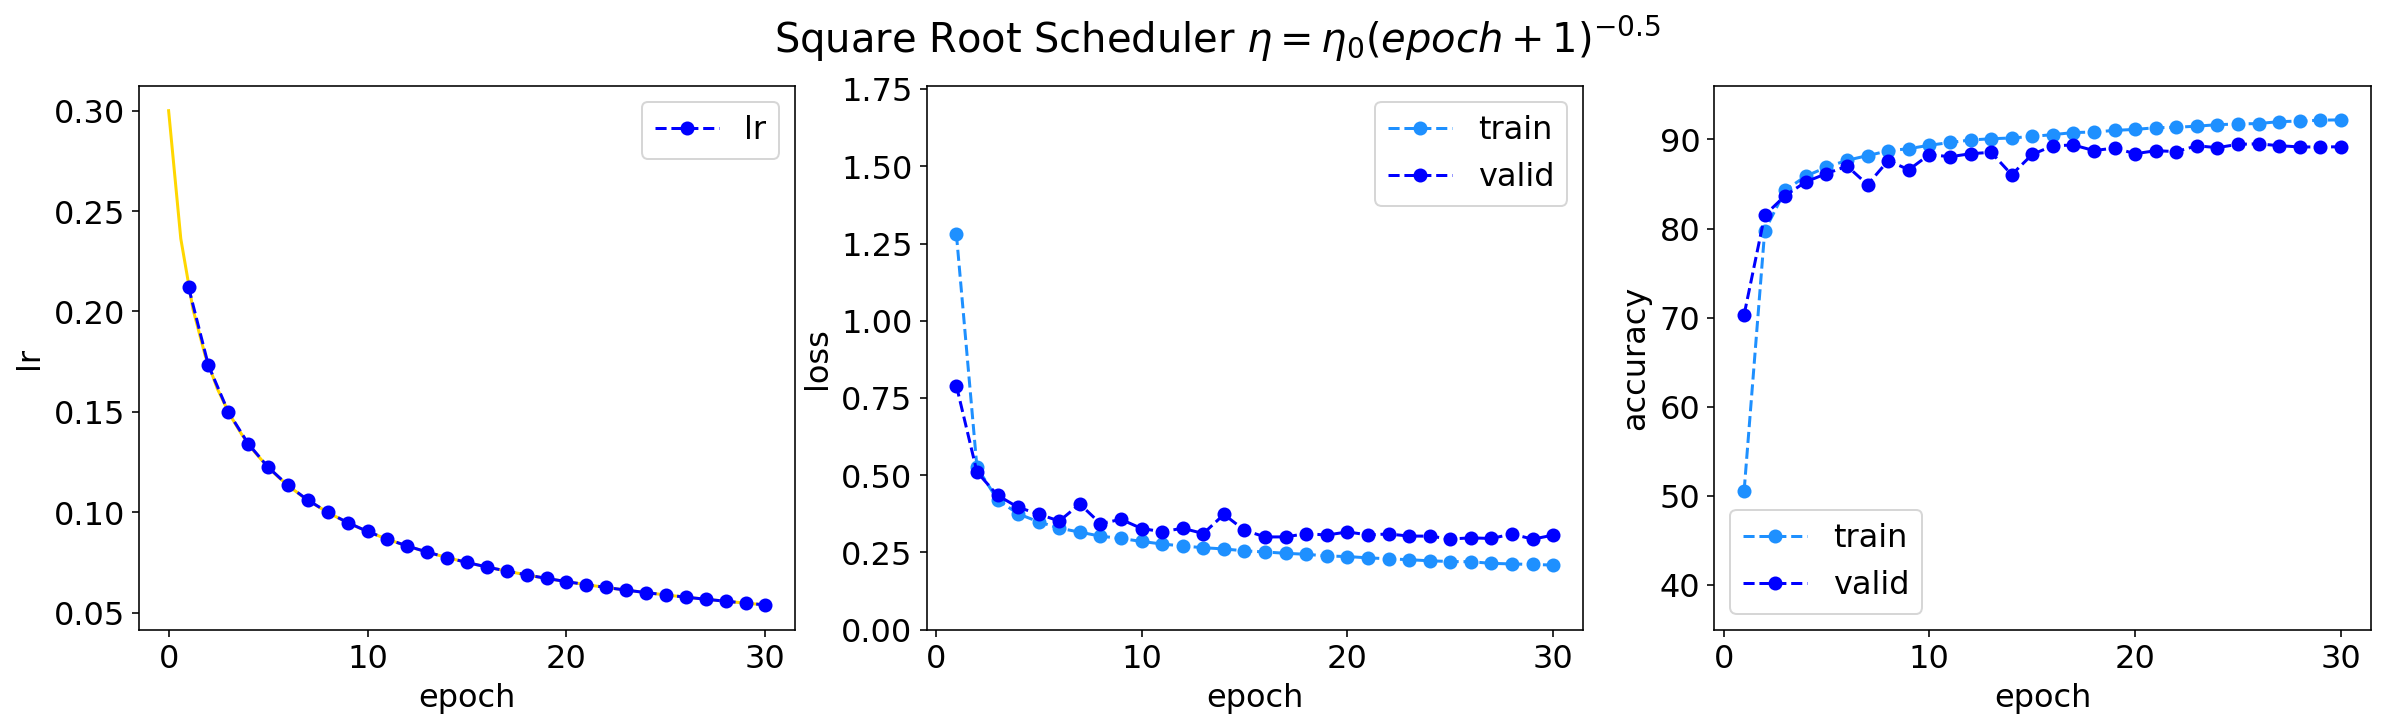

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1), lr_record, 'o--', label='lr', color='b')
ax[0].set_ylabel('lr')
x = np.linspace(0, num_epochs, 50)
ax[0].plot(x, initial_lr*(x+1)**-0.5, color='gold', zorder=-1)

ax[1].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='b')
ax[2].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='dodgerblue')
ax[2].plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='valid', color='b')

ax[1].set_ylabel('loss')
ax[2].set_ylabel('accuracy')

ax[1].set_ylim(0, 1.76)
ax[2].set_ylim(35, 96)


for i in range(3):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

fig.suptitle('Square Root Scheduler $\eta = \eta_0(epoch+1)^{-0.5}$ ', fontsize=20)

## Other Types of Schedulers

### Factor Scheduler

``torch.optim.lr_scheduler.MultiplicativeLR``

In [15]:
net = net_fn()
net.to(device)

initial_lr = 0.5 # initial learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=initial_lr)

In [16]:
factor = 0.9
lmbda = lambda epoch : factor   # eta = eta*(factor)^epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lmbda)

In [17]:
train_lossF = []
train_accF = []
valid_lossF = []
valid_accF = []
lr_recordF = []

num_epochs = 30
for epoch in range(0, num_epochs):
    train_1_epoch(net, optimizer, train_lossF, train_accF, lr_recordF, scheduler)
    validation(net, valid_lossF, valid_accF)

>>> End epoch 1, train accuracy = 33.21%, train avgLoss = 1.7681
>>>              valid accuracy = 67.92%, valid avgLoss = 0.7935
>>> End epoch 4, train accuracy = 85.11%, train avgLoss = 0.3936
>>>              valid accuracy = 84.70%, valid avgLoss = 0.3988
>>> End epoch 7, train accuracy = 87.81%, train avgLoss = 0.3197
>>>              valid accuracy = 86.51%, valid avgLoss = 0.3671
>>> End epoch 10, train accuracy = 89.28%, train avgLoss = 0.2842
>>>              valid accuracy = 87.34%, valid avgLoss = 0.3480
>>> End epoch 13, train accuracy = 90.14%, train avgLoss = 0.2603
>>>              valid accuracy = 88.29%, valid avgLoss = 0.3263
>>> End epoch 16, train accuracy = 90.81%, train avgLoss = 0.2434
>>>              valid accuracy = 88.25%, valid avgLoss = 0.3286
>>> End epoch 19, train accuracy = 91.25%, train avgLoss = 0.2310
>>>              valid accuracy = 88.46%, valid avgLoss = 0.3178
>>> End epoch 22, train accuracy = 91.61%, train avgLoss = 0.2215
>>>              val

Text(0.5, 0.98, 'Factor Scheduler   $\\eta_t = \\eta_0 * (factor)^{epoch}$')

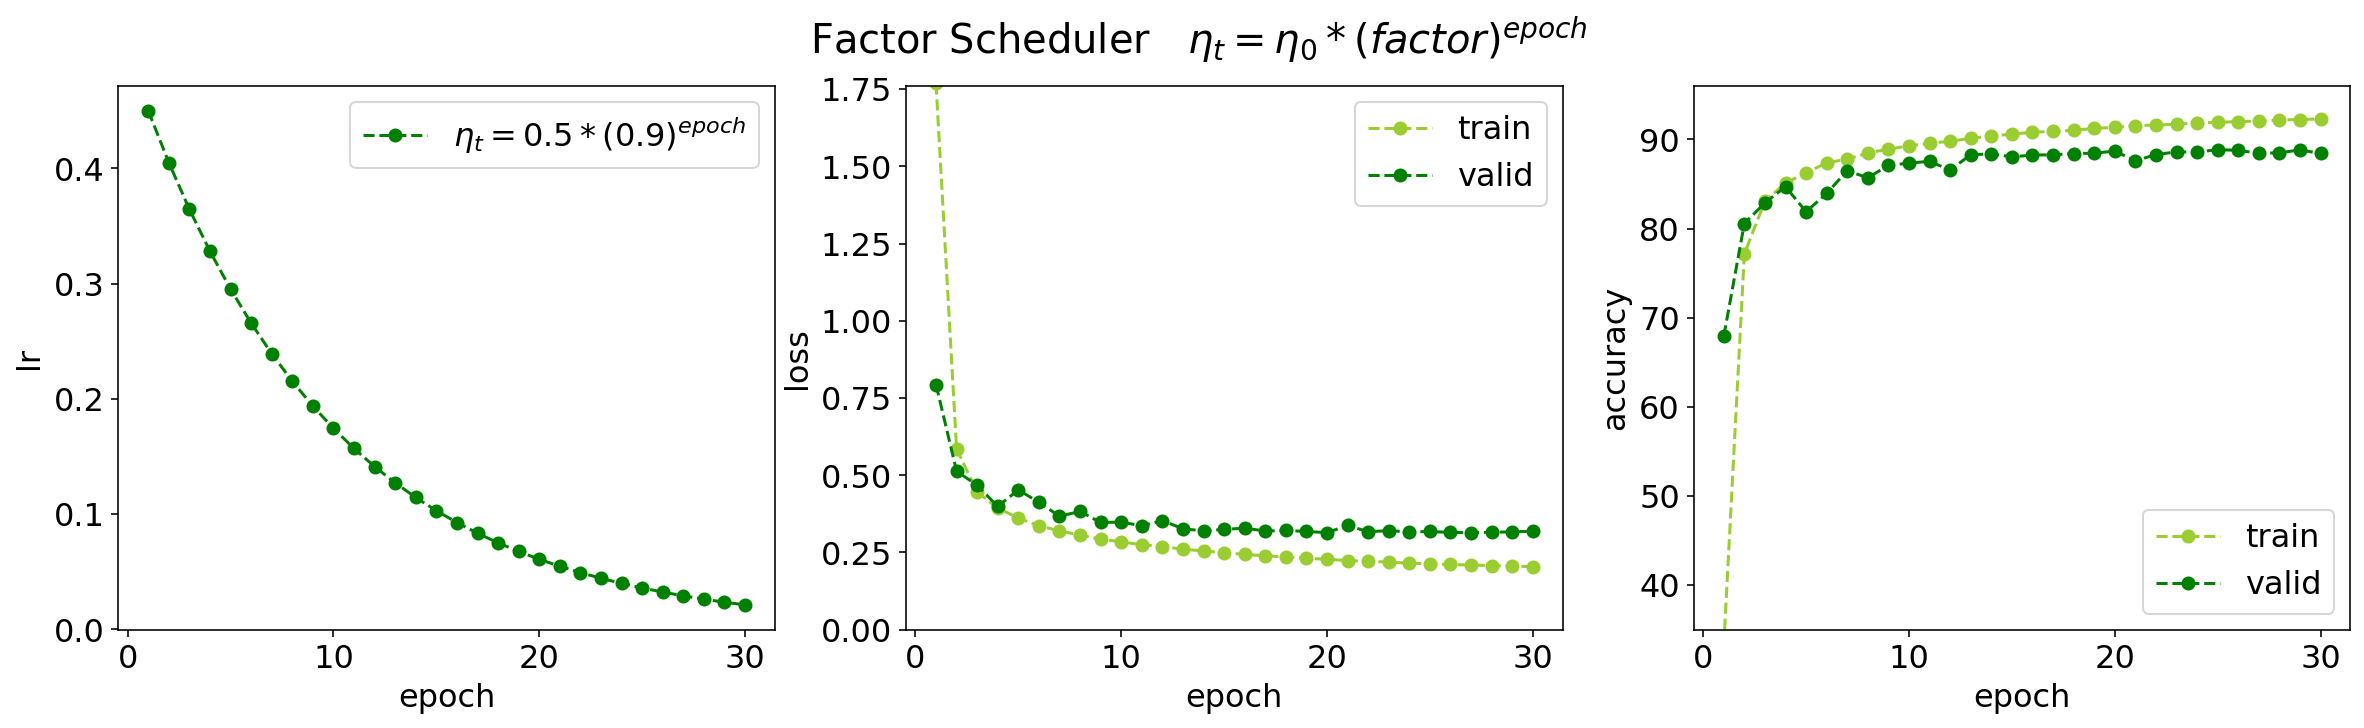

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1), lr_recordF, 'o--', label='$\eta_t = 0.5 * (0.9)^{epoch}$', color='green')
ax[0].set_ylabel('lr')
#x = np.linspace(0, num_epochs, 50)
#ax[0].plot(x, initial_lr*(x+1)**-0.5, color='gold', zorder=-1)

ax[1].plot(range(1,num_epochs+1)[::], train_lossF[::], 'o--', label='train', color='yellowgreen')
ax[1].plot(range(1,num_epochs+1)[::], valid_lossF[::], 'o--', label='valid', color='green')
ax[2].plot(range(1,num_epochs+1)[::], train_accF[::] , 'o--', label='train', color='yellowgreen')
ax[2].plot(range(1,num_epochs+1)[::], valid_accF[::], 'o--', label='valid', color='green')

ax[1].set_ylabel('loss')
ax[2].set_ylabel('accuracy')

ax[1].set_ylim(0, 1.76)
ax[2].set_ylim(35, 96)

for i in range(3):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

fig.suptitle('Factor Scheduler   $\eta_t = \eta_0 * (factor)^{epoch}$', fontsize=20)

### Multi Factor Scheduler 

```torch.optim.lr_scheduler.MultiStepLR```

In [19]:
net = net_fn()
net.to(device)

initial_lr = 0.5 # initial learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=initial_lr)

In [20]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30], gamma=0.5)

In [21]:
train_lossS = []
train_accS = []
valid_lossS = []
valid_accS = []
lr_recordS = []

num_epochs = 30
for epoch in range(0, num_epochs):
    train_1_epoch(net, optimizer, train_lossS, train_accS, lr_recordS, scheduler)
    validation(net, valid_lossS, valid_accS)

>>> End epoch 1, train accuracy = 42.70%, train avgLoss = 1.5323
>>>              valid accuracy = 59.55%, valid avgLoss = 0.9189
>>> End epoch 4, train accuracy = 83.21%, train avgLoss = 0.4461
>>>              valid accuracy = 81.98%, valid avgLoss = 0.4832
>>> End epoch 7, train accuracy = 86.68%, train avgLoss = 0.3530
>>>              valid accuracy = 84.23%, valid avgLoss = 0.4298
>>> End epoch 10, train accuracy = 87.98%, train avgLoss = 0.3178
>>>              valid accuracy = 84.36%, valid avgLoss = 0.4216
>>> End epoch 13, train accuracy = 88.91%, train avgLoss = 0.2950
>>>              valid accuracy = 86.26%, valid avgLoss = 0.3755
>>> End epoch 16, train accuracy = 90.86%, train avgLoss = 0.2415
>>>              valid accuracy = 88.21%, valid avgLoss = 0.3147
>>> End epoch 19, train accuracy = 91.33%, train avgLoss = 0.2264
>>>              valid accuracy = 87.30%, valid avgLoss = 0.3656
>>> End epoch 22, train accuracy = 91.78%, train avgLoss = 0.2159
>>>              val

Text(0.5, 0.98, 'piecewise constant learning rate schedule')

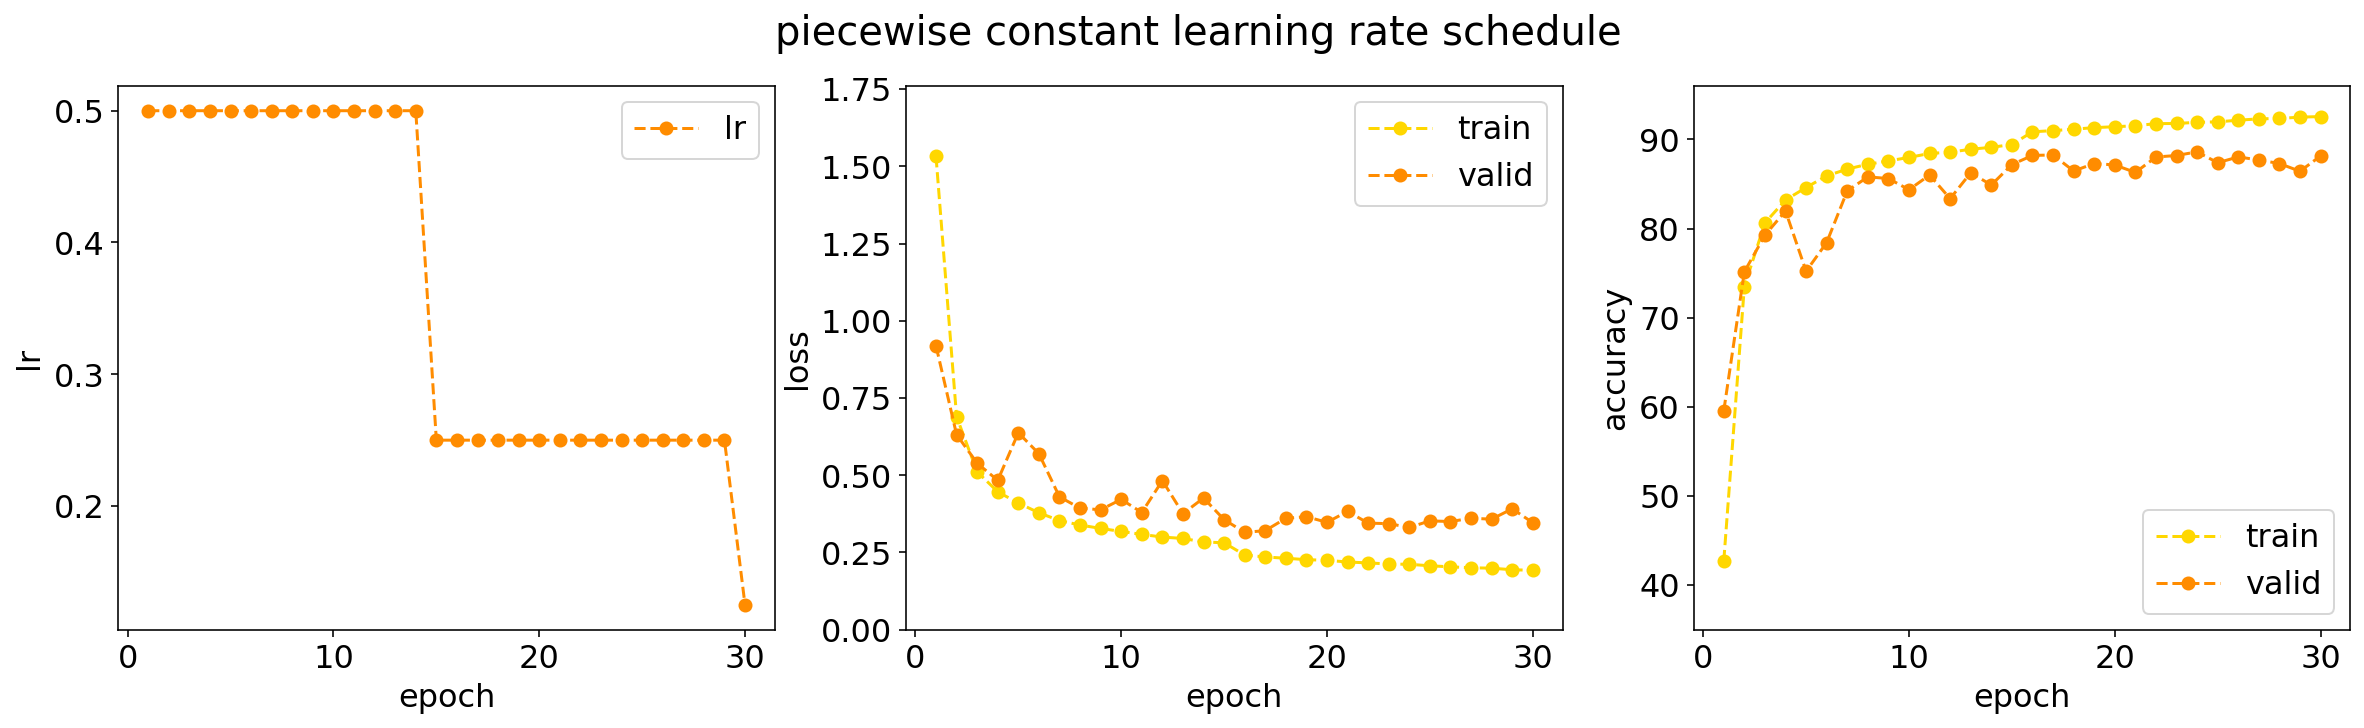

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1), lr_recordS, 'o--', label='lr', color='darkorange')
ax[0].set_ylabel('lr')

ax[1].plot(range(1,num_epochs+1)[::], train_lossS[::], 'o--', label='train', color='gold')
ax[1].plot(range(1,num_epochs+1)[::], valid_lossS[::], 'o--', label='valid', color='darkorange')
ax[2].plot(range(1,num_epochs+1)[::], train_accS[::] , 'o--', label='train', color='gold')
ax[2].plot(range(1,num_epochs+1)[::], valid_accS[::], 'o--', label='valid', color='darkorange')

ax[1].set_ylabel('loss')
ax[2].set_ylabel('accuracy')

ax[1].set_ylim(0, 1.76)
ax[2].set_ylim(35, 96)


for i in range(3):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

fig.suptitle('piecewise constant learning rate schedule', fontsize=20)

### Cosine Scheduler

- Cosine learning rate schedules have been found to work well empirically on some problems.

``torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0)``

$\eta_{\rm t} = \eta_{\rm min} + \frac{\eta_{\rm max} - \eta_{\rm min}}{2}(1+\cos(\frac{\rm T_{\rm curr\_epoch}}{T_{\rm max}}\pi))$

- $\eta_{\rm max}$ = initial learning rate

```torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0, T_mult, eta_min)```




**Intuition behind Cyclical Learning Rate Scheduler**

- The learning rate is bounded between $\eta_{\rm min}$ and $\eta_{\rm max}$.

<img src='./images/fig_optimization.png' width='720'/>

&emsp;&emsp;&emsp;&emsp;  <sub>* Image Credit : https://towardsdatascience.com/https-medium-com-reina-wang-tw-stochastic-gradient-descent-with-restarts-5f511975163 </sub>

- By increasing the learning rate from time to time, we are encouraging the model to “jump” from one local minimum to another more stable solution. -> Better generalization.

In [23]:
net = net_fn()
net.to(device)

initial_lr = 0.3 # initial learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=initial_lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.001)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.001)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

In [24]:
train_lossC = []
train_accC = []
valid_lossC = []
valid_accC = []
lr_recordC = []

num_epochs = 30
for epoch in range(0, num_epochs):
    train_1_epoch(net, optimizer, train_lossC, train_accC, lr_recordC, scheduler)

    validation(net, valid_lossC, valid_accC)

>>> End epoch 1, train accuracy = 50.92%, train avgLoss = 1.2805
>>>              valid accuracy = 66.81%, valid avgLoss = 0.8210
>>> End epoch 4, train accuracy = 85.44%, train avgLoss = 0.3917
>>>              valid accuracy = 84.16%, valid avgLoss = 0.4257
>>> End epoch 7, train accuracy = 88.31%, train avgLoss = 0.3146
>>>              valid accuracy = 86.49%, valid avgLoss = 0.3636
>>> End epoch 10, train accuracy = 89.36%, train avgLoss = 0.2883
>>>              valid accuracy = 87.85%, valid avgLoss = 0.3338
>>> End epoch 13, train accuracy = 89.31%, train avgLoss = 0.2888
>>>              valid accuracy = 87.82%, valid avgLoss = 0.3348
>>> End epoch 16, train accuracy = 88.70%, train avgLoss = 0.3022
>>>              valid accuracy = 87.10%, valid avgLoss = 0.3503
>>> End epoch 19, train accuracy = 88.46%, train avgLoss = 0.3028
>>>              valid accuracy = 85.88%, valid avgLoss = 0.3705
>>> End epoch 22, train accuracy = 89.49%, train avgLoss = 0.2776
>>>              val

Text(0.5, 0.98, 'Cosine Scheduler')

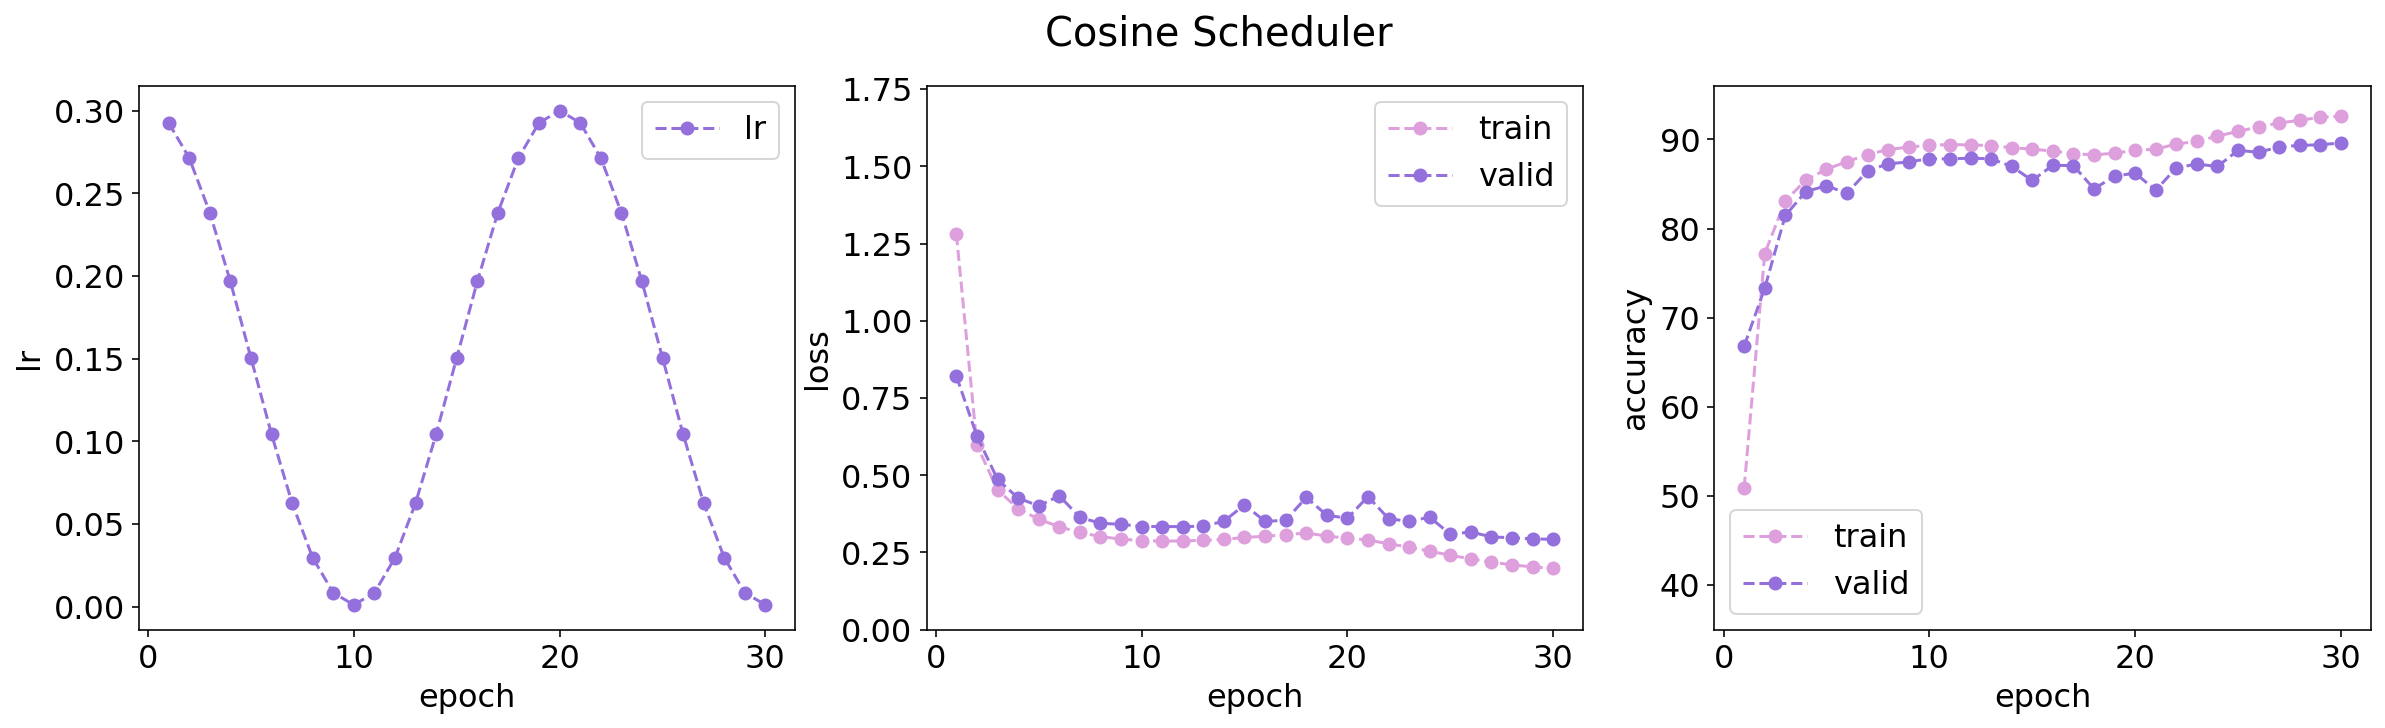

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1), lr_recordC, 'o--', label='lr', color='mediumpurple')
ax[0].set_ylabel('lr')
#x = np.linspace(0, num_epochs, 50)
#ax[0].plot(x, initial_lr*(x+1)**-0.5, color='gold', zorder=-1)

ax[1].plot(range(1,num_epochs+1)[::], train_lossC[::], 'o--', label='train', color='plum')
ax[1].plot(range(1,num_epochs+1)[::], valid_lossC[::], 'o--', label='valid', color='mediumpurple')
ax[2].plot(range(1,num_epochs+1)[::], train_accC[::] , 'o--', label='train', color='plum')
ax[2].plot(range(1,num_epochs+1)[::], valid_accC[::], 'o--', label='valid', color='mediumpurple')

ax[1].set_ylabel('loss')
ax[2].set_ylabel('accuracy')

ax[1].set_ylim(0, 1.76)
ax[2].set_ylim(35, 96)


for i in range(3):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

fig.suptitle('Cosine Scheduler', fontsize=20)

### Warmup

- On some problems it's beneficial to warm up the optimizer prior to using large learning rates.

- When dealing with an unstable optimization problems, having a large learning rate initially may lead to divergence. 

- A rather simple fix for this dilemma is to use a warmup period during which the learning rate increases to its initial maximum and to cool down the rate until the end of the optimization process.

## Summary 

### Test Accuracy vs Epochs for models trained with various learning rate schedulers on the FashionMNIST dataset.

- Compared with the default constant learning rate, sometimes dynamically adjusting the learning rate scheduler could make the learning curve rather **smoother**, and with **less overfitting** (i.e. the gaps between training loss and validation loss become smaller). 

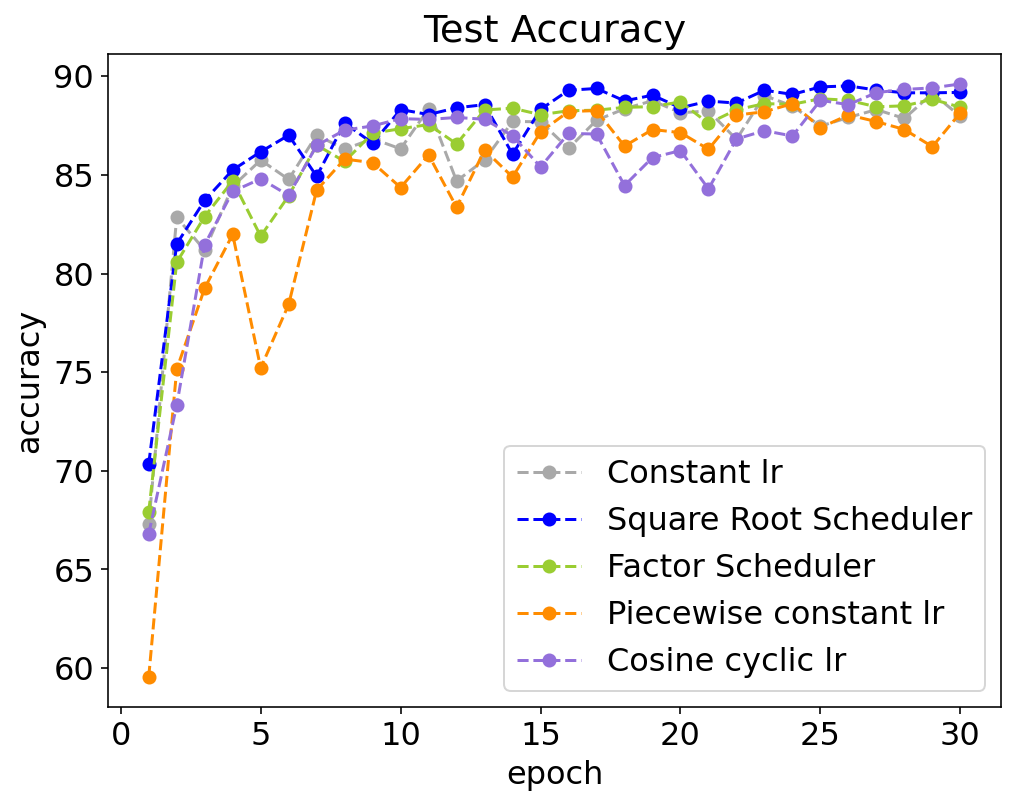

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.rc('font', size=16)

ax.plot(range(1,num_epochs+1), valid_acc0, 'o--', label='Constant lr', color='darkgray')
ax.plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='Square Root Scheduler', color='b')
ax.plot(range(1,num_epochs+1)[::], valid_accF[::], 'o--', label='Factor Scheduler', color='yellowgreen')
ax.plot(range(1,num_epochs+1)[::], valid_accS[::], 'o--', label='Piecewise constant lr', color='darkorange')
ax.plot(range(1,num_epochs+1)[::], valid_accC[::], 'o--', label='Cosine cyclic lr', color='mediumpurple')

ax.set_title('Test Accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')

ax.legend(loc='best')

# References

- [Guide to Pytorch Learning Rate Scheduling (Kaggle)](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook)
- [A Newbie’s Guide to Stochastic Gradient Descent With Restarts](https://towardsdatascience.com/https-medium-com-reina-wang-tw-stochastic-gradient-descent-with-restarts-5f511975163)

# ------------ End ------------

### quickly checking lr(t) without training 